<a href="https://colab.research.google.com/github/jisilvia/COVID_19_Reopening/blob/main/COVID_19_Reopening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19: Reopening counties while avoiding further outbreaks.

Given its current circumstances, should a county reopen to prevent a second outbreak of COVID 19? We will answer this question by identifying similar counties, which can be referred to when deciding whether a county should expect a spike in infection rates if it were to reopen given the current circumstances. 

To reach a conclusion, we will use Ensemble Models to find the optimal algorithm; run a Logistic Regression Model to identify what factors affect infection rates the most; and lastly create a kNN recommender system to identify similar counties in order to predict whether a spike in infection rates will occur or not.*italicized text*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Column Descriptions
These descriptions are based on the columns in the final dataset *finaldata.csv*

* **fips**: Unique county identifier code
* **county**: County name
* **state**: State name
* **date**: Date of the record
* **cases**: The number of new cases of Covid-19 reported that day
* **cases_per_100k**: The *cases* per 100,000 people
* **cases_avg**: The average number of new cases reported that day and the six days prior
* **cases_avg_per_100k**: The *cases_avg* per 100,000 people
* **deaths**: The total number of new deaths from Covid-19 reported that day
* **deaths_avg**: The average number of new deaths reported that day and the six days prior
* **deaths_avg_per_100k**: The *deaths_avg* per 100,000 people
* **never**: Percentage of population per county that never wears a mask
* **rarely** Percentage of population per county that rarely wears a mask
* **sometimes**: Percentage of population per county that sometimes wears a mask
* **frequently**: Percentage of population per county that frequently wears a mask
* **always**: Percentage of population per county that always wears a mask
* **population**: Population per county
* **people fully vaccinated - resident**: Number of people who are fully vaccinated 
* **percent of total pop fully vaccinated - resident**: Percentage of the  population who are fully vaccinated
* **people 18+ fully vaccinated - resident**: Number of people over the age of 18 who are fully vaccinated
* **percent of 18+ pop fully vaccinated - resident**: Percentage of the  population over the age of 18 who are fully vaccinated
* **people 65+ fully vaccinated - resident**: Number of people over the age of 65 who are fully vaccinated
* **percent of 65+ pop fully vaccinated - resident**: Percentage of the  population over the age of 65 who are fully vaccinated
* **y**: 1 = spike in infection rate; 0 = no spike in infection rate

## Reopening tiers and definitions
In order to define spikes in infection rate, we referenced the below table that classifies reopening tiers based on the number of daily new cases per 100,000 people. We classified anything over 10 new cases as a spike in infection rates.

*Source: NPR*

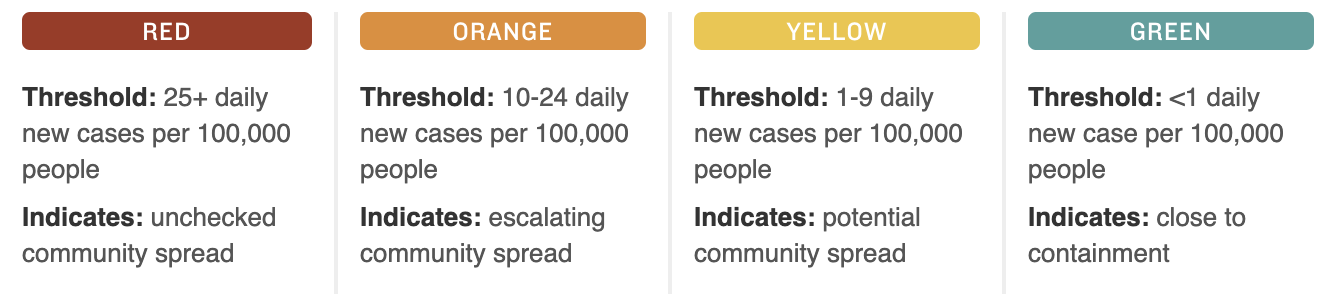

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing modules
import pandas as pd
import numpy as np
from termcolor import colored as cl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, classification_report, confusion_matrix, roc_auc_score, log_loss, jaccard_similarity_score as jss 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

%matplotlib inline

from google.colab import drive

In [ ]:
# Mounting Google Drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing datasets
data_avg = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties.csv')

data = pd.read_csv('/content/drive/MyDrive/MSBA_Colab_2020/ML_Algorithms/Project Data/us-counties.csv')

data_live = pd.read_csv('/content/drive/MyDrive/MSBA_Colab_2020/ML_Algorithms/Project Data/us-counties-live.csv')

mask_use = pd.read_csv('/content/drive/MyDrive/MSBA_Colab_2020/ML_Algorithms/Project Data/mask-use-by-county.csv')

deaths = pd.read_csv('/content/drive/MyDrive/MSBA_Colab_2020/ML_Algorithms/Project Data/deaths_cleaned.csv') #already cleaned

fips = pd.read_csv('/content/drive/MyDrive/MSBA_Colab_2020/ML_Algorithms/Project Data/fips.csv')

vaccination = pd.read_csv('/content/drive/MyDrive/MSBA_Colab_2020/ML_Algorithms/Project Data/all_states_vaccinations.csv') #already cleaned

population = pd.read_csv('/content/drive/MyDrive/MSBA_Colab_2020/ML_Algorithms/Project Data/population_data (1).csv')

finaldata = pd.read_csv('/content/drive/MyDrive/MSBA_Colab_2020/ML_Algorithms/Project Data/finaldata.csv')

In [ ]:
# Previewing data
data_avg.head(2)

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0


In [ ]:
data_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290713 entries, 0 to 1290712
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   date                 1290713 non-null  object 
 1   geoid                1290713 non-null  object 
 2   county               1290713 non-null  object 
 3   state                1290713 non-null  object 
 4   cases                1290713 non-null  int64  
 5   cases_avg            1290713 non-null  float64
 6   cases_avg_per_100k   1276726 non-null  float64
 7   deaths               1290713 non-null  int64  
 8   deaths_avg           1290713 non-null  float64
 9   deaths_avg_per_100k  1276726 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 98.5+ MB


In [ ]:
data.head(2)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248308 entries, 0 to 1248307
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   date    1248308 non-null  object 
 1   county  1248308 non-null  object 
 2   state   1248308 non-null  object 
 3   fips    1236887 non-null  float64
 4   cases   1248308 non-null  int64  
 5   deaths  1220811 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 57.1+ MB


In [ ]:
data_live.head(2)

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2021-04-23,Autauga,Alabama,1001.0,6819,107.0,5785.0,94.0,1034.0,13.0
1,2021-04-23,Baldwin,Alabama,1003.0,20815,303.0,14686.0,227.0,6129.0,76.0


In [ ]:
data_live.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3247 entries, 0 to 3246
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3247 non-null   object 
 1   county            3247 non-null   object 
 2   state             3247 non-null   object 
 3   fips              3216 non-null   float64
 4   cases             3247 non-null   int64  
 5   deaths            3169 non-null   float64
 6   confirmed_cases   2223 non-null   float64
 7   confirmed_deaths  1530 non-null   float64
 8   probable_cases    1925 non-null   float64
 9   probable_deaths   1045 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 253.8+ KB


In [ ]:
#anomalities.head(2)

In [ ]:
#anomalities.info()

In [ ]:
mask_use.info() #cleand data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   COUNTYFP    3142 non-null   int64  
 1   NEVER       3142 non-null   float64
 2   RARELY      3142 non-null   float64
 3   SOMETIMES   3142 non-null   float64
 4   FREQUENTLY  3142 non-null   float64
 5   ALWAYS      3142 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 147.4 KB


In [ ]:
mask_use.head(2)

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436


In [ ]:
deaths.info() #cleaned data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6490 entries, 0 to 6489
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     6490 non-null   object 
 1   frequency   6490 non-null   object 
 2   start_date  6490 non-null   object 
 3   end_date    6490 non-null   object 
 4   year        6490 non-null   object 
 5   month       6490 non-null   int64  
 6   week        6490 non-null   float64
 7   deaths      6490 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 405.8+ KB


In [ ]:
deaths.head(2)

,country,frequency,start_date,end_date,year,month,week,deaths
0,Austria,weekly,2020-01-06,2020-01-12,2020,1,2.0,1702
1,Austria,weekly,2020-01-13,2020-01-19,2020,1,3.0,1797


In [ ]:
fips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UID             4193 non-null   int64  
 1   iso2            4190 non-null   object 
 2   iso3            4191 non-null   object 
 3   code3           4191 non-null   float64
 4   FIPS            3384 non-null   float64
 5   Admin2          3343 non-null   object 
 6   Province_State  3999 non-null   object 
 7   Country_Region  4193 non-null   object 
 8   Lat             4050 non-null   float64
 9   Long_           4050 non-null   float64
 10  Combined_Key    4193 non-null   object 
 11  Population      4050 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 393.2+ KB


In [ ]:
fips.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.0,NaN,NaN,NaN,Afghanistan,33.93911,67.709953,Afghanistan,38928341.0
1,8,AL,ALB,8.0,NaN,NaN,NaN,Albania,41.15330,20.168300,Albania,2877800.0


In [ ]:
vaccination.info() #cleaned data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   County                                            2776 non-null   object 
 1   People Fully Vaccinated - Resident                2776 non-null   float64
 2   Percent of Total Pop Fully Vaccinated - Resident  2776 non-null   float64
 3   People 18+ Fully Vaccinated - Resident            2776 non-null   float64
 4   Percent of 18+ Pop Fully Vaccinated - Resident    2776 non-null   float64
 5   People 65+ Fully Vaccinated - Resident            2776 non-null   float64
 6   Percent of 65+ Pop Fully Vaccinated - Resident    2776 non-null   float64
 7   State                                             2776 non-null   object 
dtypes: float64(6), object(2)
memory usage: 173.6+ KB


In [ ]:
vaccination.head(2)

,County,People Fully Vaccinated - Resident,Percent of Total Pop Fully Vaccinated - Resident,People 18+ Fully Vaccinated - Resident,Percent of 18+ Pop Fully Vaccinated - Resident,People 65+ Fully Vaccinated - Resident,Percent of 65+ Pop Fully Vaccinated - Resident,State
0,Autauga,8285.0,14.8,8269.0,19.3,3665.0,41.1,Alabama
1,Baldwin,45140.0,20.2,45073.0,25.7,25269.0,54.0,Alabama


##Exploratory Data Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248308 entries, 0 to 1248307
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   date    1248308 non-null  object 
 1   county  1248308 non-null  object 
 2   state   1248308 non-null  object 
 3   fips    1236887 non-null  float64
 4   cases   1248308 non-null  int64  
 5   deaths  1220811 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 57.1+ MB


In [ ]:
data.isnull().sum()

date          0
county        0
state         0
fips      11421
cases         0
deaths    27497
dtype: int64

# Data Cleaning

In [ ]:
# Cleaned so far:
# fips dics
# mask use
# data
# data average
# data live

#all except anomalities -> drop anomatlies datasets 

### FIPS lookup table

In [ ]:
# fips lookup table

# Removing other countries from fips
fips = fips[fips.Country_Region == 'US']

# Renaming columns
fips.rename(columns={'Admin2':'county'}, inplace=True)

# Dropping null values 
fips = fips.dropna(subset=['county'], axis=0)
fips = fips.dropna(subset=['FIPS'], axis=0)

fips['FIPS'] = fips.FIPS.astype(int)

# Creating lookup dictionary
fips_lookup = fips.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])

In [ ]:
fips_dict = fips_lookup.drop(columns=['Province_State','Population'])

In [ ]:
fips_dict.head()

,FIPS,county
793,72001,Adjuntas
794,72003,Aguada
795,72005,Aguadilla
796,72007,Aguas Buenas
797,72009,Aibonito


### Data
Range: 2020-01-21 - 2021-04-22

In [ ]:
# Checking for null values
data.isnull().sum()

date          0
county        0
state         0
fips      11421
cases         0
deaths    27497
dtype: int64

In [ ]:
# Dropping unknown counties 
data = data[data.county != 'Unknown']

# Fixing counties 
data.county.replace('New York City','New York', inplace=True)
data.county.replace('Kansas City','Jackson', inplace=True)
data.county.replace('Joplin','Jasper', inplace=True)

# Filling in FIPS from lookup table
fips_na = data[data.fips.isna()]
fips_na = fips_na.merge(fips_dict, how='left',on='county')
fips_na['fips'] = fips_na.FIPS
fips_na.drop(columns='FIPS', inplace=True)

# Joining new fips with original table
data = data.append(fips_na)
data = data.dropna(axis=0, subset=['fips'])

# Removing Puerto Rico
data = data[data.state != 'Puerto Rico']

In [ ]:
# Checking for nulls
data.isna().sum()

date      0
county    0
state     0
fips      0
cases     0
deaths    0
dtype: int64

### Mask use 
Mask use per county, by population %

In [ ]:
# Adding counties to mask use
mask_use = mask_use.set_index('COUNTYFP').join(fips_lookup.set_index('FIPS'))
mask_use.head(1)

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,county,Province_State,Population
COUNTYFP,,,,,,,,
1001,0.053,0.074,0.134,0.295,0.444,Autauga,Alabama,55869.0


In [ ]:
# Checking nulls
mask_use.isna().sum()

NEVER             0
RARELY            0
SOMETIMES         0
FREQUENTLY        0
ALWAYS            0
county            0
Province_State    0
Population        0
dtype: int64

### Average data
Cases and deaths per 100k
For surge/spike definitions

In [ ]:
# Previewing
data_avg.head()

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0


In [ ]:
# Checking nulls
data_avg.isna().sum()

date                       0
geoid                      0
county                     0
state                      0
cases                      0
cases_avg                  0
cases_avg_per_100k     14011
deaths                     0
deaths_avg                 0
deaths_avg_per_100k    14011
dtype: int64

In [ ]:
# Changing data types
data_avg['date']= pd.to_datetime(data_avg.date)

# Dropping US territories
data_avg = data_avg[(data_avg.state != 'Virgin Islands') & (data_avg.state != 'Guam') & (data_avg.state != 'Northern Mariana Islands') & (data_avg.state != 'Puerto Rico')]

# Dropping nulls
data_avg = data_avg.dropna(axis=0, subset=['cases_avg_per_100k'])

# Checking nulls
data_avg.isna().sum()

date                   0
geoid                  0
county                 0
state                  0
cases                  0
cases_avg              0
cases_avg_per_100k     0
deaths                 0
deaths_avg             0
deaths_avg_per_100k    0
dtype: int64

In [ ]:
# Fixing counties 
data_avg.county.replace('New York City','New York', inplace=True)
data_avg.county.replace('Kansas City','Jackson', inplace=True)
data_avg.county.replace('Joplin','Jasper', inplace=True)

In [ ]:
data_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1249659 entries, 0 to 1293952
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date                 1249659 non-null  datetime64[ns]
 1   geoid                1249659 non-null  object        
 2   county               1249659 non-null  object        
 3   state                1249659 non-null  object        
 4   cases                1249659 non-null  int64         
 5   cases_avg            1249659 non-null  float64       
 6   cases_avg_per_100k   1249659 non-null  float64       
 7   deaths               1249659 non-null  int64         
 8   deaths_avg           1249659 non-null  float64       
 9   deaths_avg_per_100k  1249659 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 104.9+ MB


### Live data
Current cases updated daily

In [ ]:
# Previewing data
data_live.head(2)

,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2021-04-23,Autauga,Alabama,1001.0,6819,107.0,5785.0,94.0,1034.0,13.0
1,2021-04-23,Baldwin,Alabama,1003.0,20815,303.0,14686.0,227.0,6129.0,76.0


In [ ]:
data_live.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3247 entries, 0 to 3246
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3247 non-null   object 
 1   county            3247 non-null   object 
 2   state             3247 non-null   object 
 3   fips              3216 non-null   float64
 4   cases             3247 non-null   int64  
 5   deaths            3169 non-null   float64
 6   confirmed_cases   2223 non-null   float64
 7   confirmed_deaths  1530 non-null   float64
 8   probable_cases    1925 non-null   float64
 9   probable_deaths   1045 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 253.8+ KB


In [ ]:
# Checking for nulla
data_live.isna().sum()

date                   0
county                 0
state                  0
fips                  31
cases                  0
deaths                78
confirmed_cases     1024
confirmed_deaths    1717
probable_cases      1322
probable_deaths     2202
dtype: int64

In [ ]:
# Checking county nulls
na = data_live[data_live.fips.isna()]
na.county.unique()

array(['Bristol Bay plus Lake and Peninsula', 'Unknown',
       'Yakutat plus Hoonah-Angoon', 'Joplin', 'Kansas City',
       'New York City'], dtype=object)

In [ ]:
# Fixing counties 
data_live.county.replace('New York City','New York', inplace=True)
data_live.county.replace('Kansas City','Jackson', inplace=True)
data_live.county.replace('Joplin','Jasper', inplace=True)

# Dropping duplicates
data_live = data_live[(data_live.county != 'Jackson') & (data_live.state != 'Missouri') & (data_live.cases != 42761)]

fips_na = data_live[data_live.county == 'New York']

# Filling in FIPS from lookup table
fips_na = fips_na.merge(fips_dict, how='left',on='county')
fips_na['fips'] = fips_na.FIPS
fips_na.drop(columns='FIPS', inplace=True)

# Joining new fips with original table
data_live = data_live.append(fips_na)

# Dropping remaining nulls
data_live = data_live.dropna(axis=0, subset=['fips'])

# Checking nulls
data_live.isna().sum()

date                   0
county                 0
state                  0
fips                   0
cases                  0
deaths                78
confirmed_cases     1004
confirmed_deaths    1594
probable_cases      1294
probable_deaths     2061
dtype: int64

In [ ]:
# Dropping Puerto Rico
data_live = data_live[data_live.state != 'Puerto Rico']

# Checking nulls
data_live.isna().sum()

date                   0
county                 0
state                  0
fips                   0
cases                  0
deaths                 0
confirmed_cases     1004
confirmed_deaths    1516
probable_cases      1294
probable_deaths     1983
dtype: int64

In [ ]:
# Dropping other columns 
data_live = data_live.drop(columns=['confirmed_cases','confirmed_deaths','probable_cases','probable_deaths'])

###Population Data


In [ ]:
population.head()

,State,County,Population,Unnamed: 3
0,Alabama,Autauga,"55,869",NaN
1,Alabama,Baldwin,"223,234",NaN
2,Alabama,Barbour,"24,686",NaN
3,Alabama,Bibb,"22,394",NaN
4,Alabama,Blount,"57,826",NaN


In [ ]:
population.drop('Unnamed: 3', axis=1, inplace=True)

In [ ]:
population.info()

bool_series = pd.isnull(population["State"]) 

population[bool_series]

population.dropna(inplace=True)

population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       3114 non-null   object
 1   County      3141 non-null   object
 2   Population  3142 non-null   object
dtypes: object(3)
memory usage: 73.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3114 entries, 0 to 3141
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       3114 non-null   object
 1   County      3114 non-null   object
 2   Population  3114 non-null   object
dtypes: object(3)
memory usage: 97.3+ KB


In [ ]:
population.to_csv('population.csv', index=False)
#!cp population.csv "drive/My Drive/MSBA_Colab_2020/ML_Algorithms/"

In [ ]:
population.head(2)

,State,County,Population
0,Alabama,Autauga,"55,869"
1,Alabama,Baldwin,"223,234"


##Datasets' Columns: 
**data_avg:**
date	geoid	county	state	cases	cases_avg	cases_avg_per_100k	deaths	deaths_avg	deaths_avg_per_100k

**data:**
date	county	state	fips	cases	deaths

**data_live:**
date	county	state	fips	cases	deaths

**mask_use:**
NEVER	RARELY	SOMETIMES	FREQUENTLY	ALWAYS	county	Province_State	Population

**fips:**
UID	iso2	iso3	code3	FIPS	county	Province_State	Country_Region	Lat	Long_	Combined_Key	Population

**vaccination:**
County	People Fully Vaccinated - Resident	Percent of Total Pop Fully Vaccinated - Resident	People 18+ Fully Vaccinated - Resident	Percent of 18+ Pop Fully Vaccinated - Resident	People 65+ Fully Vaccinated - Resident	Percent of 65+ Pop Fully Vaccinated - Resident	State


Since **fips** is a lookup-table datasetes and we don't need to use that after we got all the other datasets that already limited to U.S. 

And **data_live** and  **data** datasets are both cumulative cases records based on the files' notations so we gonna only keep the **data_avg** datasets. 

In [ ]:
mask_use.head()

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,county,Province_State,Population
COUNTYFP,,,,,,,,
1001,0.053,0.074,0.134,0.295,0.444,Autauga,Alabama,55869.0
1003,0.083,0.059,0.098,0.323,0.436,Baldwin,Alabama,223234.0
1005,0.067,0.121,0.120,0.201,0.491,Barbour,Alabama,24686.0
1007,0.020,0.034,0.096,0.278,0.572,Bibb,Alabama,22394.0
1009,0.053,0.114,0.180,0.194,0.459,Blount,Alabama,57826.0


In [ ]:
vaccination.head(10)

,County,People Fully Vaccinated - Resident,Percent of Total Pop Fully Vaccinated - Resident,People 18+ Fully Vaccinated - Resident,Percent of 18+ Pop Fully Vaccinated - Resident,People 65+ Fully Vaccinated - Resident,Percent of 65+ Pop Fully Vaccinated - Resident,State
0,Autauga,8285.0,14.8,8269.0,19.3,3665.0,41.1,Alabama
1,Baldwin,45140.0,20.2,45073.0,25.7,25269.0,54.0,Alabama
2,Barbour,3600.0,14.6,3599.0,18.4,2239.0,46.1,Alabama
3,Bibb,2929.0,13.1,2924.0,16.4,1532.0,41.0,Alabama
4,Blount,6446.0,11.1,6441.0,14.5,3594.0,33.2,Alabama
5,Bullock,2489.0,24.6,2485.0,31.1,984.0,57.5,Alabama
6,Butler,3041.0,15.6,3040.0,20.0,1717.0,42.4,Alabama
7,Calhoun,21975.0,19.3,21952.0,24.6,11193.0,54.5,Alabama
8,Chambers,4670.0,14.0,4662.0,17.7,2451.0,36.5,Alabama
9,Cherokee,4176.0,15.9,4175.0,19.6,2435.0,39.5,Alabama


In [ ]:
data_avg.date

0         2020-01-21
1         2020-01-22
2         2020-01-23
3         2020-01-24
4         2020-01-24
             ...    
1293948   2021-05-05
1293949   2021-05-05
1293950   2021-05-05
1293951   2021-05-05
1293952   2021-05-05
Name: date, Length: 1249659, dtype: datetime64[ns]

In [ ]:
data_live[data_live['date'] == '2021-04-23']

,date,county,state,fips,cases,deaths
0,2021-04-23,Autauga,Alabama,1001.0,6819,107.0
1,2021-04-23,Baldwin,Alabama,1003.0,20815,303.0
2,2021-04-23,Barbour,Alabama,1005.0,2289,56.0
3,2021-04-23,Bibb,Alabama,1007.0,2573,62.0
4,2021-04-23,Blount,Alabama,1009.0,6563,133.0
...,...,...,...,...,...,...
3243,2021-04-23,Teton,Wyoming,56039.0,3715,9.0
3244,2021-04-23,Uinta,Wyoming,56041.0,2157,12.0
3245,2021-04-23,Washakie,Wyoming,56043.0,897,26.0
3246,2021-04-23,Weston,Wyoming,56045.0,647,5.0


In [ ]:
data_live[data_live['county'] == 'Wake']

,date,county,state,fips,cases,deaths
1995,2021-04-23,Wake,North Carolina,37183.0,90924,723.0


In [ ]:
data_avg.head()

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0


In [ ]:
(297/918702) * 100000

32.328219596778936

In [ ]:
population[population['County'] == 'Erie']

,State,County,Population
1842,New York,Erie,"918,702"


In [ ]:
data[(data.county == 'New York') & (data.date == '2021-04-20')]

,date,county,state,fips,cases,deaths
12343,2021-04-20,New York,New York,36061.0,909652,32178.0


In [ ]:
data['date']

0        2020-01-21
1        2020-01-22
2        2020-01-23
3        2020-01-24
4        2020-01-24
            ...    
12405    2021-04-22
12406    2021-04-22
12407    2021-04-22
12408    2021-04-22
12409    2021-04-22
Name: date, Length: 1221800, dtype: object

##Merge Datasets (include data_avg, mask_use, vaccination) 

In [ ]:
vaccination.rename(columns= {'County': 'county'}, inplace=True)

In [ ]:
finaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 23 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   fips                                              2711 non-null   int64  
 1   county                                            2711 non-null   object 
 2   state                                             2711 non-null   object 
 3   date                                              2711 non-null   object 
 4   cases                                             2711 non-null   int64  
 5   cases_per_100k                                    2711 non-null   int64  
 6   cases_avg                                         2711 non-null   float64
 7   cases_avg_per_100k                                2711 non-null   float64
 8   deaths                                            2711 non-null   int64  
 9   deaths_avg         

#Model Development

In [ ]:
finaldata.head()

,cases_per_100k,deaths,never,rarely,sometimes,frequently,always,population,people fully vaccinated - resident,percent of total pop fully vaccinated - resident,people 18+ fully vaccinated - resident,percent of 18+ pop fully vaccinated - resident,people 65+ fully vaccinated - resident,percent of 65+ pop fully vaccinated - resident,y
county,,,,,,,,,,,,,,,
Weston,14,0,0.142,0.129,0.148,0.207,0.374,6927,1475.0,21.3,1474.0,26.7,853.0,57.7,1
Washakie,0,0,0.204,0.155,0.069,0.285,0.287,7805,1951.0,25.0,1951.0,32.4,1106.0,63.9,0
Uinta,4,0,0.098,0.278,0.154,0.207,0.264,20226,4485.0,22.2,4484.0,31.0,1907.0,63.0,0
Teton,17,0,0.095,0.157,0.160,0.247,0.340,23464,11765.0,50.1,11710.0,60.8,2858.0,76.9,1
Sweetwater,18,0,0.061,0.295,0.230,0.146,0.268,42343,9477.0,22.4,9447.0,30.1,3794.0,69.1,1


In [ ]:
finaldata['y'] = [1 if x >= 10 else 0  for x in finaldata['cases_per_100k']]

##Ensemble Methods

In [ ]:
# install xgboost package
!pip install xgboost

In [ ]:
# import necessary packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# divide our dataset into train and test set
finaldata['y'].value_counts()

X_var = np.asarray(finaldata.drop(['y', 
                                  'fips', 
                                  'county',
                                  'state', 
                                  'date', 
                                  'cases',
                                  'cases_per_100k',
                                  'cases_avg',	
                                  'cases_avg_per_100k',
                                  'deaths_avg',
                                  'deaths'], axis = 1))

y_var = np.asarray(finaldata['y'])

#display how the variables look like within the first 5 indexes
print(cl('X_var samples : ', attrs = ['bold']), X_var[:5])
print(cl('y_var samples : ', attrs = ['bold']), y_var[:5])



X_var samples :  [[0.0000e+00 1.4200e-01 1.2900e-01 1.4800e-01 2.0700e-01 3.7400e-01
  6.9270e+03 1.4750e+03 2.1300e+01 1.4740e+03 2.6700e+01 8.5300e+02
  5.7700e+01]
 [0.0000e+00 2.0400e-01 1.5500e-01 6.9000e-02 2.8500e-01 2.8700e-01
  7.8050e+03 1.9510e+03 2.5000e+01 1.9510e+03 3.2400e+01 1.1060e+03
  6.3900e+01]
 [0.0000e+00 9.8000e-02 2.7800e-01 1.5400e-01 2.0700e-01 2.6400e-01
  2.0226e+04 4.4850e+03 2.2200e+01 4.4840e+03 3.1000e+01 1.9070e+03
  6.3000e+01]
 [0.0000e+00 9.5000e-02 1.5700e-01 1.6000e-01 2.4700e-01 3.4000e-01
  2.3464e+04 1.1765e+04 5.0100e+01 1.1710e+04 6.0800e+01 2.8580e+03
  7.6900e+01]
 [0.0000e+00 6.1000e-02 2.9500e-01 2.3000e-01 1.4600e-01 2.6800e-01
  4.2343e+04 9.4770e+03 2.2400e+01 9.4470e+03 3.0100e+01 3.7940e+03
  6.9100e+01]]
y_var samples :  [1 0 0 1 1]


In [ ]:
#split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(X_var,
                                                    y_var,
                                                    test_size = 0.3, 
                                                    random_state = 4)
#take a look for the splited data for X and y 
print(cl('X_train samples : ', attrs = ['bold']), X_train[:5])
print(cl('X_test samples : ', attrs = ['bold']), X_test[:5])
print(cl('y_train samples : ', attrs = ['bold']), y_train[:10])
print(cl('y_test samples : ', attrs = ['bold']), y_test[:10])

X_train samples :  [[2.53000e+00 1.63000e-01 1.60000e-01 1.31000e-01 1.62000e-01 3.83000e-01
  5.63600e+03 1.46900e+03 2.61000e+01 1.46600e+03 3.50000e+01 6.24000e+02
  5.35000e+01]
 [0.00000e+00 6.10000e-02 5.50000e-02 3.00000e-02 2.27000e-01 6.27000e-01
  5.50620e+04 1.28480e+04 2.33000e+01 1.28270e+04 2.84000e+01 6.58500e+03
  4.94000e+01]
 [0.00000e+00 3.40000e-02 7.80000e-02 2.56000e-01 2.47000e-01 3.85000e-01
  7.70700e+03 2.02600e+03 2.63000e+01 2.02500e+03 3.41000e+01 1.07400e+03
  6.87000e+01]
 [0.00000e+00 8.40000e-02 5.10000e-02 2.74000e-01 2.69000e-01 3.21000e-01
  3.88850e+04 9.72200e+03 2.50000e+01 9.70200e+03 3.21000e+01 4.49400e+03
  6.25000e+01]
 [0.00000e+00 6.60000e-02 8.00000e-02 2.13000e-01 2.21000e-01 4.19000e-01
  1.21154e+05 2.91710e+04 2.41000e+01 2.91350e+04 3.07000e+01 1.50660e+04
  6.29000e+01]]
X_test samples :  [[0.0000e+00 7.5000e-02 3.1000e-02 3.5000e-02 1.5100e-01 7.0800e-01
  4.2222e+04 1.0752e+04 2.5500e+01 1.0730e+04 3.0900e+01 5.8890e+03
  5.8400e+0

## Building a Random Forest Model 

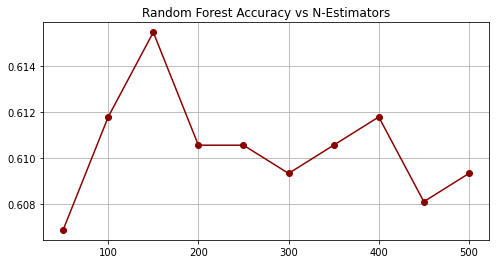

In [ ]:
# create a list to store accuracy scores
accuracies = []
# create a list to store all the n_estimator values we want to test
n_estimators = [50,100,150,200,250,300,350,400,450,500]

# create a for loop that instantiates a different random forest classifier
# and calculates the accuracy for each n_estimator in the list defined above
for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n, random_state=101) # initialize a random_state so results can be reproduced/consistent
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_test==y_pred)
    accuracies.append(accuracy)

# visualize the accuracy for each n_estimator value
plt.figure(figsize=(8,4))
pd.Series(accuracies, n_estimators).plot(color='darkred',marker='o')
plt.title('Random Forest Accuracy vs N-Estimators')
plt.grid()
plt.show()

## Building AdaBoost, Gradient Boost (classifier) and XGB model

### Ada-Boost Classifier

In [ ]:
# import necessary packages
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

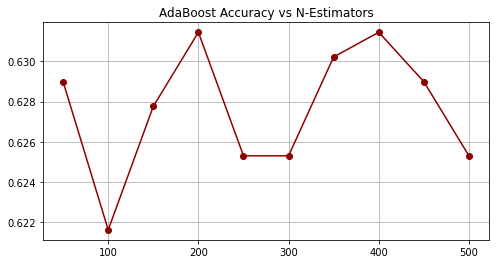

In [ ]:
# create a list to store accuracy scores
accuracies2 = []
# create a for loop that instantiates a different AdaBoost classifier
# and calculates the accuracy for each n_estimator in the list defined above
for n in n_estimators:
    model = AdaBoostClassifier(n_estimators=n, random_state=101)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_test==y_pred)
    accuracies2.append(accuracy)

# visualize the accuracy for each n_estimator value
plt.figure(figsize=(8,4))
pd.Series(accuracies2, n_estimators).plot(color='darkred',marker='o')
plt.title('AdaBoost Accuracy vs N-Estimators')
plt.grid()
plt.show()

## Gradient Boost Classifier

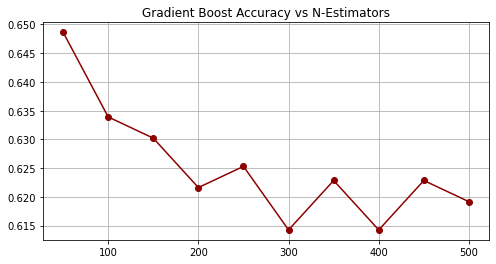

In [ ]:
# create a list to store accuracy scores
accuracies3 = []
# create a for loop that instantiates a different Gradient Boost classifier
# and calculates the accuracy for each n_estimator in the list defined above
for n in n_estimators:
    model = GradientBoostingClassifier(n_estimators=n, random_state=101)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_test==y_pred)
    accuracies3.append(accuracy)

# visualize the accuracy for each n_estimator value
plt.figure(figsize=(8,4))
pd.Series(accuracies3, n_estimators).plot(color='darkred',marker='o')
plt.title('Gradient Boost Accuracy vs N-Estimators')
plt.grid()
plt.show()

## XG-Boost Classifier

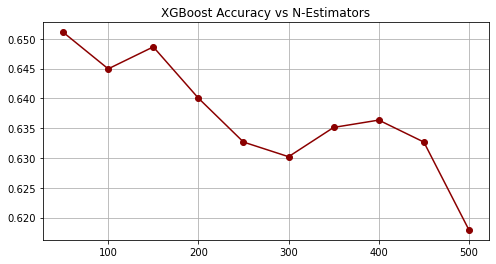

In [ ]:
# create a list to store accuracy scores
accuracies4 = []
# create a for loop that instantiates a different XGB classifier
# and calculates the accuracy for each n_estimator in the list defined above
for n in n_estimators:
    model = XGBClassifier(n_estimators=n, random_state=101)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_test==y_pred)
    accuracies4.append(accuracy)

# visualize the accuracy for each n_estimator value
plt.figure(figsize=(8,4))
pd.Series(accuracies4, n_estimators).plot(color='darkred',marker='o')
plt.title('XGBoost Accuracy vs N-Estimators')
plt.grid()
plt.show()

In [ ]:
# we take the n_estimator with the best accuracy score for the random forest classifier
# and store it in a variable
best_n_estimator = 150
# instantiate all models using the best n estimator
rand_mod = RandomForestClassifier(n_estimators=best_n_estimator, random_state=101)
adab_mod = AdaBoostClassifier(n_estimators=best_n_estimator, random_state=101)
grad_mod = GradientBoostingClassifier(n_estimators=best_n_estimator, random_state=101)
xgbo_mod = XGBClassifier(n_estimators=best_n_estimator, random_state=101)

# fit the training set to all the models 
rand_mod.fit(X_train, y_train)
adab_mod.fit(X_train, y_train)
grad_mod.fit(X_train, y_train)
xgbo_mod.fit(X_train, y_train)

# predict the test set
y_pred_rand = rand_mod.predict(X_test)
y_pred_ada = adab_mod.predict(X_test)
y_pred_grad = grad_mod.predict(X_test)
y_pred_xg = xgbo_mod.predict(X_test)

#calculate accuracy scores
accuracy_rand = np.mean(y_test==y_pred_rand)
accuracy_ada = np.mean(y_test==y_pred_ada)
accuracy_grad = np.mean(y_test==y_pred_grad)
accuracy_xg = np.mean(y_test==y_pred_xg)

# store accuracy scores in a list
accuracies = [accuracy_rand, accuracy_ada, accuracy_grad, accuracy_xg]

#calculate AUC scores
auc_rand = roc_auc_score(y_test, y_pred_rand)
auc_ada = roc_auc_score(y_test, y_pred_ada)
auc_grad = roc_auc_score(y_test, y_pred_grad)
auc_xg = roc_auc_score(y_test, y_pred_xg)

# store AUC scores in a list
auc_scores = [auc_rand, auc_ada, auc_grad, auc_xg]

# create dataframe/table
n_estimators = [150, 150, 150, 150]
random_states = [101, 101, 101, 101]

pd.DataFrame.from_dict(data={'Accuracy': accuracies, 'AUC': auc_scores, 'n_estimators': n_estimators, 'Random State': random_states}, 
                       orient='index', columns=['Random Forest', 'AdaBoost', 'Gradient Boost', 'XGB'])

,Random Forest,AdaBoost,Gradient Boost,XGB
Accuracy,0.615479,0.627764,0.630221,0.648649
AUC,0.604661,0.618072,0.619804,0.639295
n_estimators,150.000000,150.000000,150.000000,150.000000
Random State,101.000000,101.000000,101.000000,101.000000


### XBG Model Evaluation

In [ ]:
# Classification report
print(classification_report(y_test, y_pred_xg, digits=4))

# Precision = ratio of true positive predictions vs total predicted positives
# Recall = ratio of true positive predictions vs total actual positives
# F1-score = measures balance between precision and recall for accuracy

              precision    recall  f1-score   support

           0     0.6250    0.5464    0.5831       366
           1     0.6640    0.7321    0.6964       448

    accuracy                         0.6486       814
   macro avg     0.6445    0.6393    0.6397       814
weighted avg     0.6464    0.6486    0.6454       814



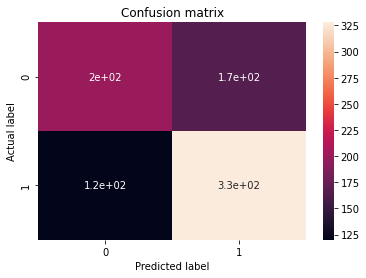

True Positives: 328
False Positives: 166
True Negatives: 200
False Negatives: 120


In [ ]:
# Confusion Matrix
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_xg)), annot=True)

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_xg).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')


# The model predicted 328 true positives out of 448 total positives. 
# In this case, we care more about the ability to predict true positives as the objective is to detect COVID surges.

In [ ]:
# Sensitivity and Specificity
sensitivity = tp/(tp+fn) # ability to predict positive outcomes
specificity = tn/(tn+fp) # ability to predict negative outcomes

print('Sensitivity: ', sensitivity, '\nSpecificity: ', specificity)

Sensitivity:  0.7321428571428571 
Specificity:  0.546448087431694


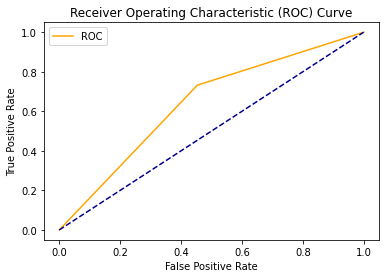

In [ ]:
# ROC curve

# definiting plot
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# defining inputs and plotting graph
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xg)
plot_roc_curve(fpr, tpr)

In [ ]:
# AUC score
print("AUC Score: ", roc_auc_score(y_test, y_pred_xg))

AUC Score:  0.6392954722872756


##Logistic Regression

In [ ]:
# Selecting the feature variables
feature_cols_lr = finaldata.drop(['y','county','fips','state','date','cases',
                               'deaths','deaths_avg','cases_avg','cases_per_100k',
                               'cases_avg_per_100k','people 18+ fully vaccinated - resident',
                               'people 65+ fully vaccinated - resident',
                               'people fully vaccinated - resident','deaths_avg_per_100k'], axis=1)

X_lr = feature_cols_lr # Features
y_lr = finaldata.y # Target variable

In [ ]:
# Splitting the Dataset into train and test data
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=35, random_state=42)

In [ ]:
# Standardizing training data by scaling
scaler = StandardScaler()

X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.fit_transform(X_test_lr)

In [ ]:
# Fit (train) the Logistic Regression Classifier using training data
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train_lr, y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Making prediction using testing data
y_pred_lr = logreg.predict(X_test_lr)

### Feature Importance

In [ ]:
# Retrieving coefficients
# The higher the coefficient, the larger the influence of its corresponding feature on the outcome
logreg.coef_

# Storing coefficients in dictionary with feature names
coef_dict = {}
for coef, feat in zip(logreg.coef_[0,:],feature_cols_lr):
    coef_dict[feat] = coef

# storing result in DataFrame including signs to show positive or negative influence
coef = pd.DataFrame.from_dict(coef_dict,orient='index', columns=['coefficient'])

#Viewing results in descending order
abs(coef).sort_values(by='coefficient', ascending=False)

,coefficient
percent of 18+ pop fully vaccinated - resident,0.864746
percent of total pop fully vaccinated - resident,0.548786
percent of 65+ pop fully vaccinated - resident,0.495810
sometimes,0.193924
rarely,0.188619
never,0.129764
population,0.115466
always,0.055529
frequently,0.031278


### Model Evaluation

In [ ]:
# Classification report
print(classification_report(y_test_lr, y_pred_lr, digits=4))

# Precision = ratio of true positive predictions vs total predicted positives
# Recall = ratio of true positive predictions vs total actual positives
# F1-score = measures balance between precision and recall for accuracy

              precision    recall  f1-score   support

           0     0.4444    0.4000    0.4211        10
           1     0.7692    0.8000    0.7843        25

    accuracy                         0.6857        35
   macro avg     0.6068    0.6000    0.6027        35
weighted avg     0.6764    0.6857    0.6805        35



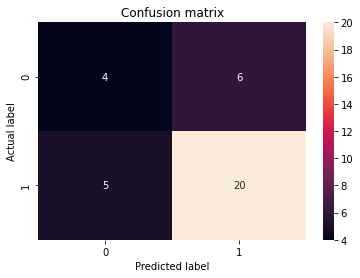

True Positives: 20
False Positives: 6
True Negatives: 4
False Negatives: 5


In [ ]:
# Confusion Matrix
sns.heatmap(pd.DataFrame(confusion_matrix(y_test_lr, y_pred_lr)), annot=True)

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test_lr, y_pred_lr).ravel()
print(f'True Positives: {tp_lr}')
print(f'False Positives: {fp_lr}')
print(f'True Negatives: {tn_lr}')
print(f'False Negatives: {fn_lr}')


# The model predicted 20 true positives out of 25 total positives. 
# In this case, we care more about the ability to predict true positives as the objective is to detect COVID surges.

In [ ]:
# Sensitivity and Specificity
sensitivity_lr = tp_lr/(tp_lr+fn_lr) # ability to predict positive outcomes
specificity_lr = tn_lr/(tn_lr+fp_lr) # ability to predict negative outcomes

print('Sensitivity: ', sensitivity_lr, '\nSpecificity: ', specificity_lr)

Sensitivity:  0.8 
Specificity:  0.4


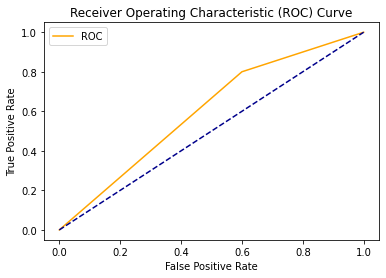

In [ ]:
# ROC curve

# definiting plot
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# defining inputs and plotting graph
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, y_pred_lr)
plot_roc_curve(fpr_lr, tpr_lr)

In [ ]:
# AUC score
print("AUC Score: ", roc_auc_score(y_test_lr, y_pred_lr))

AUC Score:  0.6000000000000001


##kNN Based Recommender Engine

In [ ]:
finaldata.set_index('county', inplace=True)

knnfinal = finaldata.drop(['state', 'fips', 'date', 'cases', 'cases_avg', 'cases_avg_per_100k',
                           'deaths_avg', 'deaths_avg_per_100k', 'y'], axis=1)
knnfinal.head()

,cases_per_100k,deaths,never,rarely,sometimes,frequently,always,population,people fully vaccinated - resident,percent of total pop fully vaccinated - resident,people 18+ fully vaccinated - resident,percent of 18+ pop fully vaccinated - resident,people 65+ fully vaccinated - resident,percent of 65+ pop fully vaccinated - resident
county,,,,,,,,,,,,,,
Weston,14,0,0.142,0.129,0.148,0.207,0.374,6927,1475.0,21.3,1474.0,26.7,853.0,57.7
Washakie,0,0,0.204,0.155,0.069,0.285,0.287,7805,1951.0,25.0,1951.0,32.4,1106.0,63.9
Uinta,4,0,0.098,0.278,0.154,0.207,0.264,20226,4485.0,22.2,4484.0,31.0,1907.0,63.0
Teton,17,0,0.095,0.157,0.160,0.247,0.340,23464,11765.0,50.1,11710.0,60.8,2858.0,76.9
Sweetwater,18,0,0.061,0.295,0.230,0.146,0.268,42343,9477.0,22.4,9447.0,30.1,3794.0,69.1


In [ ]:
# import NearestNeighbors package for our model
from sklearn.neighbors import NearestNeighbors

# instantiate the NearestNeighbors model: it's an unsupervised learner for implementing neighbor searches
# our goal is to find the 5 nearest neighbor (5 most similar movies) to 'The Post'
mod = NearestNeighbors(metric='cosine', algorithm='brute')

# fit the dataframe containing all the movies
mod.fit(knnfinal)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
# for easier readability and reusability, we'll create a function
# the argument will be the (county name, attributes)

def get_similar_counties(county_name, attributes):
    '''
    county_name type: str
    attributes type: nested list

    '''
    # look for the 5 nearest neighbors (5 movies with most similar attributes) to 'The Post' [n_neighbors hyperparameter]
    # then assign the distance and index of each movie into variables distances and indices
    
    distances, indices = mod.kneighbors(attributes, n_neighbors=5)

    # print the 5 most similar movies and their distances
    print(cl('Similar counties to {}...\n'.format(county_name), attrs=['bold']))
    for i in indices[0]:
        print('  ',knnfinal.index[i])
          
# call the function
get_similar_counties('Weston', [[14, 0,	0.142,0.129,0.148,0.207,0.374,6927,1475.0,21.3,1474.0,26.7,853.0,57.7]])
#Weston	14	0	0.142	0.129	0.148	0.207	0.374	6927	1475.0	21.3	1474.0	26.7	853.0	57.7

Similar counties to Weston...

   Weston
   Lincoln
   Mitchell
   Granite
   Sullivan


In [ ]:
knnfinal.loc['Los Angeles']

# call the function
get_similar_counties('Los Angeles', [[4.000000e+00, 
                                      2.600000e+01,	
                                      2.100000e-02,
                                      1.300000e-02,
                                      4.900000e-02,
                                      1.310000e-01,
                                      7.860000e-01, 
                                      1.003911e+07,
                                      2.694610e+06,
                                      2.680000e+01,
                                      2.680301e+06,
                                      3.400000e+01,
                                      8.542340e+05,
                                      6.040000e+01]])


Similar counties to Los Angeles...

   Los Angeles
   Orange
   Cleveland
   Middlesex
   Cook


###Model Evaluation 

Confusion Matrix, Classification Report 

In [ ]:
#get a performance criteria 
#black box model vs. white box model 
#accuracy, precision, recall, specificity... 

In [ ]:
# Selecting the feature variables
#['state', 'fips', 'date', 'cases', 'cases_avg', 'cases_avg_per_100k', 
#'deaths_avg', 'deaths_avg_per_100k', 'y']
feature_cols = finaldata.drop(['y','state', 'fips', 'date', 'cases', 
                               'cases_avg', 'cases_avg_per_100k', 'deaths_avg', 
                               'deaths_avg_per_100k'], axis=1)
X = feature_cols 
y = finaldata.y 

In [ ]:
# Splitting the Dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Standardizing training data by scaling
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
# Training using KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, metric='cosine', algorithm='brute', radius=1.0)
neigh.fit(X_train, y_train)


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Making prediction using testing data
from sklearn import metrics
from sklearn.metrics import *

y_pred = neigh.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred)) #0.8402234636871508


0.8402234636871508


In [ ]:
# Cross validation using 10 folds,cv=10
from sklearn.model_selection import cross_val_score

k_list= [1,3,5,7,9]
cv_scores=[]

for i in k_list:
    cross_neigh = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(cross_neigh,X_train, y_train,cv=10)
    cv_scores.append(np.mean(scores))

print(len(cv_scores))
print(cv_scores)

5
[0.7973711371501426, 0.8205057373565661, 0.8226974682775788, 0.8215955315402829, 0.8193855867889017]


In [ ]:
# Confusion matrix and classification_report
#precision = TP/TP+FP
#Recall = TP/TP+FN

from sklearn.model_selection import cross_val_predict

cross_predict = cross_val_predict(cross_neigh,X_test,y_test,cv=10)
print(metrics.accuracy_score(y_test, cross_predict))

print(metrics.confusion_matrix(y_test, cross_predict))
print(metrics.classification_report(y_test, cross_predict))

# Precision = ratio of true positive predictions vs total predicted positives
# Recall = ratio of true positive predictions vs total actual positives
# F1-score = measures balance between precision and recall for accuracy

0.8044692737430168
[[305  86]
 [ 89 415]]
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       391
           1       0.83      0.82      0.83       504

    accuracy                           0.80       895
   macro avg       0.80      0.80      0.80       895
weighted avg       0.80      0.80      0.80       895



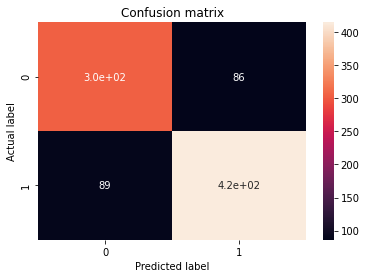

True Positives: 415
False Positives: 86
True Negatives: 305
False Negatives: 89


In [ ]:
# Confusion Matrix
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, cross_predict)), 
            annot=True)

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

tn, fp, fn, tp = metrics.confusion_matrix(y_test, cross_predict).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')


# The model predicted 20 true positives out of 25 total positives. 
# In this case, we care more about the ability to predict true positives as the objective is to detect COVID surges.

In [ ]:
# Sensitivity and Specificity
sensitivity = tp/(tp+fn) # ability to predict positive outcomes
specificity = tn/(tn+fp) # ability to predict negative outcomes

print('Sensitivity: ', sensitivity, '\nSpecificity: ', specificity)

Sensitivity:  0.8234126984126984 
Specificity:  0.7800511508951407


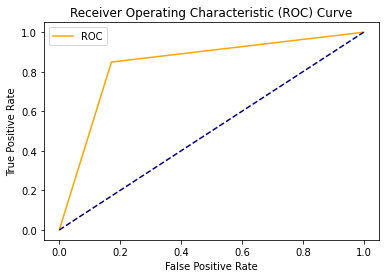

In [ ]:
# ROC curve

# definiting plot
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# defining inputs and plotting graph
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr, tpr)

In [ ]:
# AUC score
print("AUC Score: ", roc_auc_score(y_test, y_pred))

AUC Score:  0.8389254252425609
